In [1]:
from scipy.constants import Planck, gas_constant, Boltzmann
import numpy as np
import matplotlib.pyplot as plt
import json
from model import extract_thermodynamic_parameters, calculate_gibbs, eyring_rate, simulate_dna_melting

# Eyring model of DNA dissociation

What do I think is going on here? It is possible to calculate how much energy would be required to melt some dsDNA. You would do this by calculating Gibb's free energy required to overcome the bonding energy of the DNA. Each base-pairing has an energy associated with it, but it seems that is too simplistic. The nearest neighbours of a given base-pairing is very important, as it has an influence on the free energy.

You can calculate the Gibbs free energy, $G$, from the enthalpy, $H$, the entropy, $S$, and the temperature, $T$.

$$\Delta G = \Delta H - T \Delta S$$

### Enthalpy, H

Enthalpy measures the total energy of a thermodynamic system. It includes the internal energy, i.e. the energy required to create the system, and the energy required to make room for the system by displacing its environment and establishing its volume and pressure.

Enthalpy chanages in chemical reactions are often associated with breaking or forming bonds, meaning that a change in enthalpy refers to heat absorbed / released. A negative $\Delta H$ means we have an exothermic reaction, releasing energy to its surroundings. A positive $\Delta H$ means we have an endothermic reaction, where heat is absorbed from the surroundings.

For dissocation I expect $\Delta H$ to be positive.

### Entropy, S

Entropy meaures the disorder of the system. It quantifies the number of possible configurations the system can have.

A negative $\Delta S$ indicates that the system has moved toward a more ordered configuration. A positive $\Delta S$ means the system has become more disordered.

For dissociation I expect $\Delta S$ to be positive.

### Gibbs Free Energy, G

Gibbs free energy combines enthalpy and entropy to describe the maximum amount of work a thermodynamic system can perform at constant temperature and pressure. It measures the "usefulness" or "work potential" of the energy in the system.

A negative $\Delta G$ indicates that a reaction is spontaneous under constant temperature and pressure, meaning it can occur without the input of external energy. A positive $\Delta G$ suggests that the reaction is non-spontaneous, and requires energy to proceed. A $\Delta G$ of zero indicates that the system is at equilibrium, with the reaction proceeding in both forward and backwards directions with equal rates.

For dissociation I expect $\Delta G$ to be positive.

## Is this anything to with Eyring?

I don't think that any of this is really anything to do with Eyring. I am going to say that the Eyring model relates dissociation rates to Gibbs free energies. 

$$ k = \kappa \frac{k_{b} T}{h} \exp{(-\frac{\Delta G}{R T})}$$

where $\kappa$ is a dimenionless number which decides whether the DNA can re-hybridise (0 = definitely, 1=nope), $k_{b}$ is Boltzmann's constant (J/K), $h$ is Planck's constant (J.s), $R$ is the gas constant (J/mol/K), $T$ is temperature (K), $\Delta G$ is the Gibbs free energy (kcal/mol).

In order to first calculate Gibbs free energies you need some other model. This can be as simple as just concerning yourself with the energy required to pull a basepair away from its equivalent base on the complementary strand. More complicated and accurate would be to take into account the nearest neighbours of the base. This makes sense because this stacking interaction is the dominant force responsible for stabilising DNA duplexes.

If I take the values for Gibbs free energy for one of our sequences, and I just naively plug it into the equation for the Eyring model then I get crazy numbers out. I am not sure how to make sense of what this Eyring rate actually is.

## Ising Model

You can also use an Ising model for the melting, as the duplex transitions from fully duplex to totally melted.

# Melting model for short sequences (like mine!)

For short sequences the most likely states from the partition function are the fully melted state and duplex state - we don't have to worry about all these intermdeiate loop states etc. That is lucky.

$K$ is the equilibrium rate that take two complementary strands and turns them into a single duplex, and vice versa. It can also be viewed as the partition function over all states that contain at least one base. It can be calculated as a sum over all possible arrangements of the base pairing between the complementary strands in our Ising model.

$$K = \sum_{i=1}^{N} \sum_{j=i}^{N} \beta \prod_{k=i}^{j} s_{k} $$


In [2]:
param_file = "nn.json"

with open(param_file, 'r') as f:
    # Parse the JSON file and convert it into a Python dictionary
    params = json.load(f)

params = params["SantaLucia_Hicks_2004"]
params

{'AA/TT': {'dH': -7.6, 'dS': -21.3, 'dG37': -1.0},
 'AT/AT': {'dH': -7.2, 'dS': -20.4, 'dG37': -0.88},
 'TA/TA': {'dH': -7.2, 'dS': -21.3, 'dG37': -0.58},
 'CA/TG': {'dH': -8.5, 'dS': -22.7, 'dG37': -1.45},
 'GT/AC': {'dH': -8.4, 'dS': -22.4, 'dG37': -1.44},
 'CT/AG': {'dH': -7.8, 'dS': -21.0, 'dG37': -1.28},
 'GA/TC': {'dH': -8.2, 'dS': -22.2, 'dG37': -1.3},
 'CG/CG': {'dH': -10.6, 'dS': -27.2, 'dG37': -2.17},
 'GC/GC': {'dH': -9.8, 'dS': -24.4, 'dG37': -2.24},
 'GG/CC': {'dH': -8.0, 'dS': -19.9, 'dG37': -1.84},
 'initiation': {'dH': 0.2, 'dS': -5.7, 'dG37': 1.96},
 'terminal_AT_penalty': {'dH': 2.2, 'dS': 6.9, 'dG37': 0.05},
 'units': {'dH': 'kcal/mol', 'dS': 'cal/mol/K', 'dG37': 'kcal/mol'}}

Now I want to calculate the total Gibbs free energy for my sequence. I think I do this by going through the sequence, reading it off in "chunks" that are two bases long, and summing the Gibbs free energies of all the chunks.

In [41]:
seq = "AAG ATC CCG TGC ATA AAA CTG GAG T"

In [42]:
dH, dS = extract_thermodynamic_parameters(seq, params)

In [15]:
temperature = 37
temperature_K = temperature + 273.15
gibbs_kcal = calculate_gibbs(dH, dS/1000., temperature_K)
gibbs_joules = gibbs_kcal * 4184
print(f"Gibbs: {gibbs_kcal} {params['units']['dG37']}")
print(f"Gibbs: {gibbs_joules} J/mol")

Gibbs: -32.73647500000004 kcal/mol
Gibbs: -136969.4114000002 J/mol


In [19]:
temperature_range = np.linspace(20 + 273, 100 + 273, 81)
temperature_range

array([293., 294., 295., 296., 297., 298., 299., 300., 301., 302., 303.,
       304., 305., 306., 307., 308., 309., 310., 311., 312., 313., 314.,
       315., 316., 317., 318., 319., 320., 321., 322., 323., 324., 325.,
       326., 327., 328., 329., 330., 331., 332., 333., 334., 335., 336.,
       337., 338., 339., 340., 341., 342., 343., 344., 345., 346., 347.,
       348., 349., 350., 351., 352., 353., 354., 355., 356., 357., 358.,
       359., 360., 361., 362., 363., 364., 365., 366., 367., 368., 369.,
       370., 371., 372., 373.])

In [20]:
k = []
g = []
for _, j in enumerate(temperature_range):
    gibbs_ = calculate_gibbs(
    enthalpy = dH,
    entropy = dS/1000.,
    temperature = j
                        )
    gibbs_joules = gibbs_ * 4184
    g.append(gibbs_joules)
    k_ = eyring_rate(j, gibbs_joules, kappa=1)
    k.append(k_)

## Gibbs Free Energy vs T

Text(0, 0.5, '$\\Delta G$ (J/mol)')

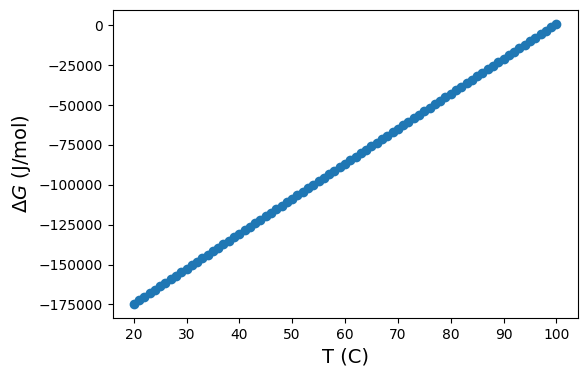

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, g)
ax.set_xlabel("T (C)", fontsize=14)
ax.set_ylabel("$\Delta G$ (J/mol)", fontsize=14)

## k vs T

Text(0, 0.5, 'k (1/s)')

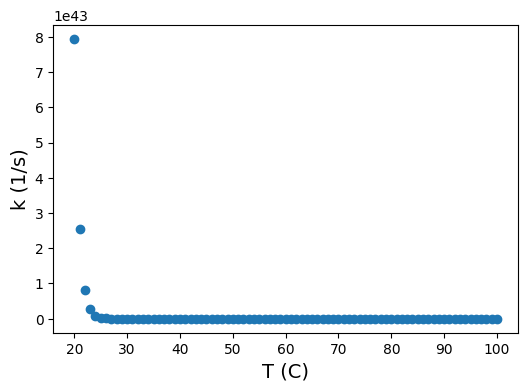

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, k)
ax.set_xlabel("T (C)", fontsize=14)
ax.set_ylabel("k (1/s)", fontsize=14)

Text(0, 0.5, 'ln(k)')

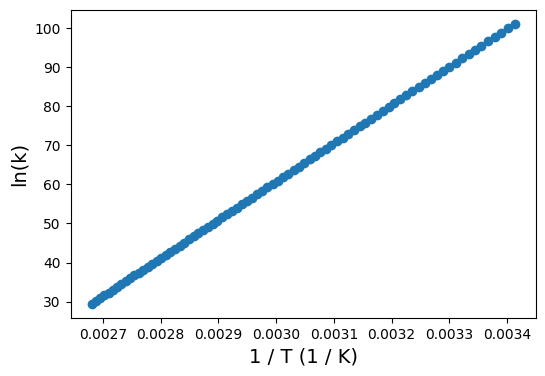

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(1 / temperature_range, np.log(k))
ax.set_xlabel("1 / T (1 / K)", fontsize=14)
ax.set_ylabel("ln(k)", fontsize=14)

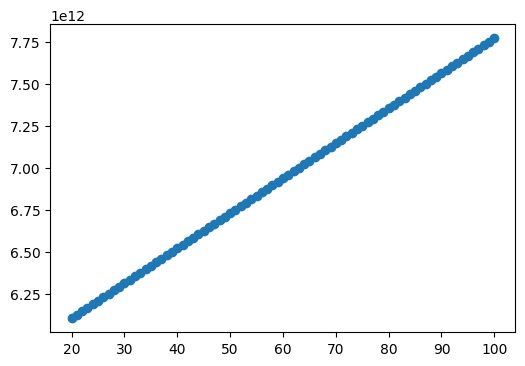

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, Boltzmann * temperature_range / Planck)

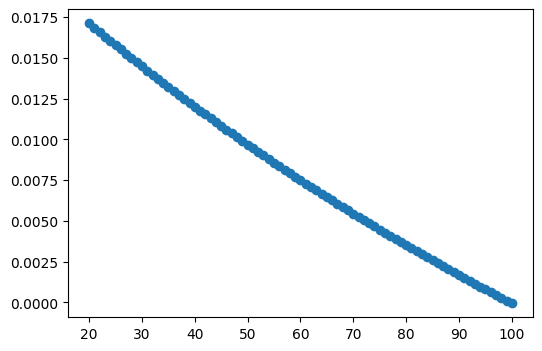

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
exponent = - np.array(g) / np.array(temperature_range) / gas_constant
ax.scatter(temperature_range - 273, exponent)

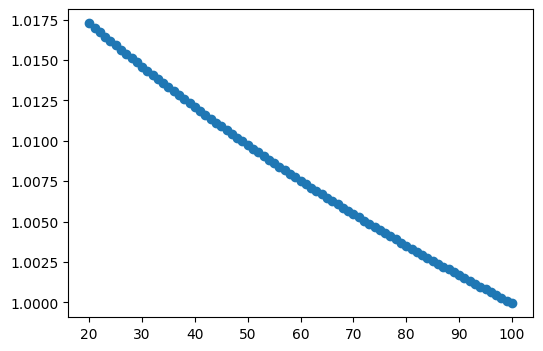

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, np.exp(exponent))

<bound method Axes.semilogy of <Axes: >>

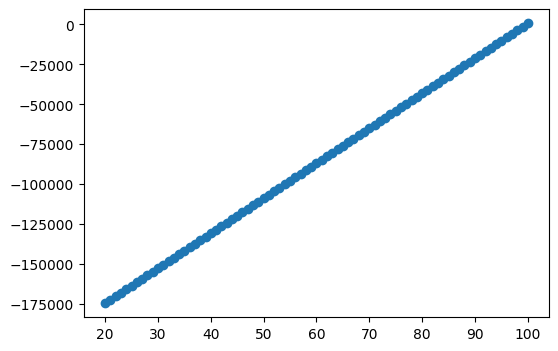

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, g)
ax.semilogy

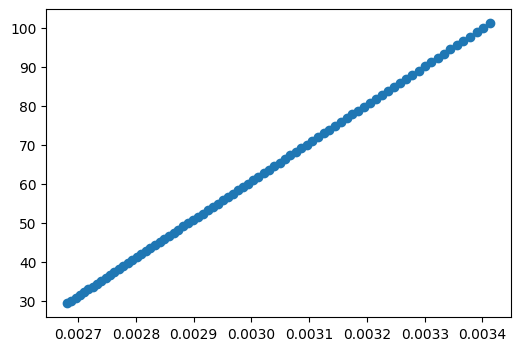

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(1 / temperature_range, np.log(k))

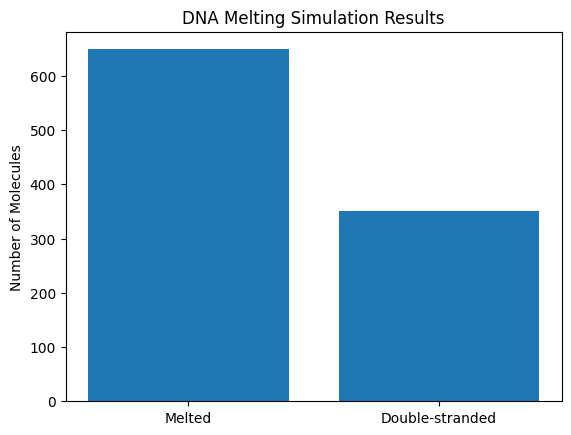

In [14]:
# Parameters
num_molecules = 1000
rate_constant = 0.001  # Example rate constant, adjust based on your model
num_steps = 1000

# Run simulation
final_states = simulate_dna_melting(num_molecules, rate_constant, num_steps)

# Calculate and print the fraction of melted DNA
fraction_double = np.sum(final_states) / num_molecules

# Plotting (optional)
plt.hist(final_states, bins=[0, 1, 2], rwidth=0.8)
plt.xticks([0.5, 1.5], ['Melted', 'Double-stranded'])
plt.ylabel('Number of Molecules')
plt.title('DNA Melting Simulation Results')
plt.show()
